In [1]:
# Author: Denis A. Engemann <denis.engemann@gmail.com>
#
# License: BSD (3-clause)

import os
import os.path as op
import random

import numpy as np

from sklearn.covariance import oas
from scipy.stats import pearsonr

import mne
from mne.minimum_norm import make_inverse_operator, apply_inverse_epochs
import mne_bids

from joblib import Parallel, delayed
from autoreject import get_rejection_threshold

import config as cfg
import library as lib
import run_make_boundary_element_models


def _get_subjects(trans_set, shuffle=True):
    trans = 'trans-%s' % trans_set
    found = os.listdir(op.join(cfg.derivative_path, trans))
    if shuffle:
        random.seed(42)
        random.shuffle(found)
    if trans_set == 'halifax':
        #subjects = [sub[4:4 + 8] for sub in found]
        subjects = [sub[0:-10] for sub in found]
    elif trans_set == 'krieger':
        subjects = ['CC' + sub[:6] for sub in found]
    print("found", len(subjects), "coregistrations")
    return subjects, [op.join(cfg.derivative_path, trans, ff) for ff in found]




# This parses the bad trial information supplied by CamCAN, which we're not using # PJ
#def _parse_bads(subject, kind):
#    sss_log = op.join(
#        max_filter_info_path, subject,
#        kind, "mf2pt2_{kind}_raw.log".format(kind=kind))

#    try:
#        bads = lib.preprocessing.parse_bad_channels(sss_log)
#    except Exception as err:
#        print(err)
#        bads = []
#    # first 100 channels omit the 0.
#    bads = [''.join(['MEG', '0', bb.split('MEG')[-1]])
#            if len(bb) < 7 else bb for bb in bads]
#    return bads


def _get_global_reject_ssp(raw):
    eog_epochs = mne.preprocessing.create_eog_epochs(raw)
    if len(eog_epochs) >= 5:
        reject_eog = get_rejection_threshold(eog_epochs, decim=8)
        del reject_eog['eog']
    else:
        reject_eog = None

    ecg_epochs = mne.preprocessing.create_ecg_epochs(raw)
    if len(ecg_epochs) >= 5:
        reject_ecg = get_rejection_threshold(ecg_epochs, decim=8)
    else:
        reject_eog = None

    if reject_eog is None:
        reject_eog = reject_ecg
    if reject_ecg is None:
        reject_ecg = reject_eog
    return reject_eog, reject_ecg


def _run_maxfilter(raw, subject, kind, coord_frame="head"):
    
    # Detect bad channels automatically, rather than reading from file #PJ
    #bads = _parse_bads(subject, kind)
    bads = lib.preprocessing.detect_bad_channels(raw, coord_frame)

    raw.info['bads'] = bads
    
    raw = lib.preprocessing.run_maxfilter(raw, coord_frame=coord_frame)
    return raw


def _compute_add_ssp_exg(raw):
    reject_eog, reject_ecg = _get_global_reject_ssp(raw)

    proj_eog = mne.preprocessing.compute_proj_eog(
        raw, average=True, reject=reject_eog, n_mag=1, n_grad=1, n_eeg=1)

    proj_ecg = mne.preprocessing.compute_proj_ecg(
        raw, average=True, reject=reject_ecg, n_mag=1, n_grad=1, n_eeg=1)

    raw.add_proj(proj_eog[0])
    raw.add_proj(proj_ecg[0])


def _get_global_reject_epochs(raw, decim):
    duration = 3.
    events = mne.make_fixed_length_events(
        raw, id=3000, start=0, duration=duration)

    epochs = mne.Epochs(
        raw, events, event_id=3000, tmin=0, tmax=duration, proj=False,
        baseline=None, reject=None)
    epochs.apply_proj()
    epochs.load_data()
    epochs.pick_types(meg=True)
    reject = get_rejection_threshold(epochs, decim=decim)
    return reject


def _apply_inverse_cov(
        cov, info, nave, inverse_operator, lambda2=1. / 9., method="dSPM",
        pick_ori=None, prepared=False, label=None,
        method_params=None, return_residual=False, verbose=None,
        log=True):
    """Apply inverse operator to evoked data HACKED
    """
    from mne.minimum_norm.inverse import _check_reference
    from mne.minimum_norm.inverse import _check_ori
    from mne.minimum_norm.inverse import _check_ch_names
    from mne.minimum_norm.inverse import _check_or_prepare
    from mne.minimum_norm.inverse import _check_ori
    from mne.minimum_norm.inverse import _pick_channels_inverse_operator
    from mne.minimum_norm.inverse import _assemble_kernel
    from mne.minimum_norm.inverse import _subject_from_inverse
    from mne.minimum_norm.inverse import _get_src_type
    from mne.minimum_norm.inverse import combine_xyz
    from mne.minimum_norm.inverse import _make_stc
    from mne.utils import _check_option
    from mne.utils import logger
    from mne.io.constants import FIFF
    from collections import namedtuple

    INVERSE_METHODS = ['MNE', 'dSPM', 'sLORETA', 'eLORETA']

    fake_evoked = namedtuple('fake', 'info')(info=info)

    _check_reference(fake_evoked, inverse_operator['info']['ch_names'])
    _check_option('method', method, INVERSE_METHODS)
    if method == 'eLORETA' and return_residual:
        raise ValueError('eLORETA does not currently support return_residual')
    
    # PJ - the next line causes an error (_check_ori missing positional arg 'src')
    #_check_ori(pick_ori, inverse_operator['source_ori'])

    
    #
    #   Set up the inverse according to the parameters
    #

    _check_ch_names(inverse_operator, info)

    inv = _check_or_prepare(inverse_operator, nave, lambda2, method,
                            method_params, prepared)

    #
    #   Pick the correct channels from the data
    #
    sel = _pick_channels_inverse_operator(cov['names'], inv)
    logger.info('Applying inverse operator to cov...')
    logger.info('    Picked %d channels from the data' % len(sel))
    logger.info('    Computing inverse...')

    K, noise_norm, vertno, source_nn = _assemble_kernel(inv, label, method,
                                                        pick_ori)
    
    # apply imaging kernel
    sol = np.einsum('ij,ij->i', K, (cov.data[sel] @ K.T).T)[:, None]

    is_free_ori = (inverse_operator['source_ori'] ==
                   FIFF.FIFFV_MNE_FREE_ORI and pick_ori != 'normal')

    if is_free_ori and pick_ori != 'vector':
        logger.info('    Combining the current components...')
        sol = combine_xyz(sol)

    if noise_norm is not None:
        logger.info('    %s...' % (method,))
        if is_free_ori and pick_ori == 'vector':
            noise_norm = noise_norm.repeat(3, axis=0)
        sol *= noise_norm

    tstep = 1.0 / info['sfreq']
    tmin = 0.0
    subject = _subject_from_inverse(inverse_operator)

    src_type = _get_src_type(inverse_operator['src'], vertno)
    if log:
        sol = np.log10(sol, out=sol)

    stc = _make_stc(sol, vertno, tmin=tmin, tstep=tstep, subject=subject,
                    vector=(pick_ori == 'vector'), source_nn=source_nn,
                    src_type=src_type)
    logger.info('[done]')

    return stc


def _compute_mne_power(subject, kind, freqs):

    ###########################################################################
    # Compute source space
    # -------------------
    src = mne.setup_source_space(subject, spacing='oct6', add_dist=False,
                                 subjects_dir=cfg.mne_camcan_freesurfer_path)
    
    
    '''
    # This section was added to compute the transform from head coords to MRI coords (rather than using Krieger/Halifax" #PJ
    # Update - now using the Halifax transforms provided by Tim Bardouille https://github.com/tbardouille/camcan_coreg #PJ
    
    meg_bids_path = mne_bids.BIDSPath(subject=subject[4:], root=cfg.camcan_meg_raw_path, session='rest', task='rest', extension='.fif', check=False)
    t1_bids_path = mne_bids.BIDSPath(subject=subject[4:], root=cfg.camcan_path + '/mri/pipeline/release004/BIDS_20190411/anat')
    trans = mne_bids.get_head_mri_trans(meg_bids_path,
                                        t1_bids_path = t1_bids_path,
                                        fs_subject=subject,
                                        fs_subjects_dir=cfg.mne_camcan_freesurfer_path)
    '''
    
    # Get transform filename #PJ
    trans = trans_map[subject]
    
    # Load boundary element model - Assumes run_make_boundary_element_models.py already run #PJ
    bem = cfg.mne_camcan_freesurfer_path + \
        "/%s/bem/%s-meg-bem.fif" % (subject, subject)


    ###########################################################################
    # Compute handle MEG data
    # -----------------------

    # Change to new BIDS format - PJ
    #    fname = op.join(
    #        cfg.camcan_meg_raw_path,
    #        subject, kind, '%s_raw.fif' % kind)

    fname = op.join(
    cfg.camcan_meg_raw_path,
    subject, kind, 'meg', '%s_%s_task-rest_meg.fif' % (subject, kind))

    raw = mne.io.read_raw_fif(fname)
    mne.channels.fix_mag_coil_types(raw.info) #Fixes size labelling for some coils # PJ
    if DEBUG:
        # raw.crop(0, 180)
        raw.crop(0, 120)
    else:
        raw.crop(0, 300)


    # Run MaxFilter without movement compensation (don't know why they run it without movement compensation - revisit) #PJ
    raw = _run_maxfilter(raw, subject, kind)
    
    # Project EOG and ECG components out of raw data #PJ
    _compute_add_ssp_exg(raw)

    # get empty room
    #fname_er = op.join(
    #    cfg.camcan_meg_path,
    #    "emptyroom",
    #    subject,
    #    "emptyroom_%s.fif" % subject)

    # Get empty room with new release filepath. #PJ
    fname_er = op.join(
        cfg.camcan_meg_path,
        "emptyroom",
        subject,
        "emptyroom",
        "emptyroom_%s.fif" % subject[4:])

    raw_er = mne.io.read_raw_fif(fname_er)
    mne.channels.fix_mag_coil_types(raw.info)

    raw_er = _run_maxfilter(raw_er, subject, kind, coord_frame='meg')
    
    # Add projections from rest recording to empty room (not sure why exactly) #PJ
    #raw_er.info["projs"] += raw.info["projs"] # This gives an error, corrected to below #PJ
    raw_er.add_proj(raw.info["projs"])
    
    # Compute covariance in empty room recording for MNE #PJ
    cov = mne.compute_raw_covariance(raw_er, method='oas')
    
    # compute before band-pass of interest

    event_length = 5.
    event_overlap = 0.
    raw_length = raw.times[-1]
    events = mne.make_fixed_length_events(
        raw,
        duration=event_length, start=0, stop=raw_length - event_length)

    #######################################################################
    # Compute the forward and inverse
    # -------------------------------

    info = mne.Epochs(raw, events=events, tmin=0, tmax=event_length,
                      baseline=None, reject=None, preload=False,
                      decim=10).info
    fwd = mne.make_forward_solution(info, trans, src, bem)
    inv = make_inverse_operator(info, fwd, cov)
    del fwd

    #######################################################################
    # Compute label time series and do envelope correlation ### I think he meant 'covariance' #PJ
    # -----------------------------------------------------
    
    # This section gets surface source labels from MNE sample data #PJ
    
    #mne_subjects_dir = "/storage/inria/agramfor/MNE-sample-data/subjects"
    
    sample_data_folder = mne.datasets.sample.data_path()
    mne_subjects_dir = os.path.join(sample_data_folder, 'subjects')
    
    #labels = mne.read_labels_from_annot('fsaverage', 'aparc_sub',
    #                                    subjects_dir=mne_subjects_dir)
    
    # not sure difference between aparc_sub and aparc_a2009s #PJ
    labels = mne.read_labels_from_annot('fsaverage', 'aparc.a2009s',
                                        subjects_dir=mne_subjects_dir)
    
    # Warp labels to this subject's surface #PJ
    labels = mne.morph_labels(
        labels, subject_from='fsaverage', subject_to=subject,
        subjects_dir=cfg.mne_camcan_freesurfer_path)
    labels = [ll for ll in labels if 'unknown' not in ll.name]

    
    # Band-pass signal to frequency band, compute sensor covariance, project to surface labels, compute covariance between labels #PJ
    results = dict()
    
    for fmin, fmax, band in freqs:
        print(f"computing {subject}: {fmin} - {fmax} Hz")
        this_raw = raw.copy()
        this_raw.filter(fmin, fmax, n_jobs=1)
        reject = _get_global_reject_epochs(this_raw, decim=5) # Get rejection threshold for band
        epochs = mne.Epochs(this_raw, events=events, tmin=0, tmax=event_length,
                            baseline=None, reject=reject, preload=True,
                            decim=5)
        if DEBUG:
            epochs = epochs[:3]

        # MNE cov mapping
        data_cov = mne.compute_covariance(epochs, method='oas')

        # Next two calls compute average power at each label?? #PJ
        stc = _apply_inverse_cov(
            cov=data_cov, info=epochs.info, nave=1,
            inverse_operator=inv, lambda2=1. / 9.,
            pick_ori='normal', method='MNE', log=False)
        # assert np.all(stc.data < 0)

        label_power = mne.extract_label_time_course(
            stc, labels, inv['src'], mode="mean")  # XXX signal should be positive

        # Compute band-limited time course at each vertex #PJ
        stcs = apply_inverse_epochs(
            epochs, inv, lambda2=1. / 9.,
            pick_ori='normal',
            method='MNE',
            return_generator=True)

        # Get band-limited time course at each label from stcs #PJ
        label_ts = np.concatenate(mne.extract_label_time_course(
            stcs, labels, inv['src'], mode="pca_flip", # PCA flip prevents random sign flips from cancelling out #PJ
            return_generator=False), axis=-1)

        # Compute label x label covariance matrix using Oracle Approximating Shrinkage Estimator #PJ
        label_cov, _ = oas(label_ts.T, assume_centered=True)
        
        # Could try envelope correlation here (not debugged): #PJ
        #from mne_connectivity import envelope_correlation
        #corr = envelope_correlation(label_ts, verbose=True)
        #corr = envelope_correlation(np.reshape(label_ts, [1,150,-1]), verbose=True)
        
        #label_ts = mne.extract_label_time_course(stcs, labels, inv['src'], return_generator=True)
        #corr = envelope_correlation(label_ts, verbose=True)
        

        if DEBUG:
            print(
                pearsonr(
                    np.log10(np.diag(label_cov)).ravel(),
                    np.log10(label_power.ravel())))

        result = {'cov': label_cov[np.triu_indices(len(label_cov))], 
                  'power': label_power, 'subject': subject,
                  'fmin': fmin, 'fmax': fmax, "band": band,
                  'label_names': [ll.name for ll in labels]}
        results[band] = result
        
        if False:
            out_fname = op.join(
                cfg.derivative_path_run_maxfilter(raw, subject, kind),
                f'{subject + ("-debug" if DEBUG else "")}_'
                f'cov_mne_{band}.h5')

            mne.externals.h5io.write_hdf5(
                out_fname, result, overwrite=True)
            
    return results, raw       


#def _run_all(subject, freqs, kind='rest'):
def _run_all(subject, freqs, kind='ses-rest'):
    mne.utils.set_log_level('warning')
    # mne.utils.set_log_level('info')
    print(subject)
    error = 'None'
    result = dict()
    if not DEBUG:
        try:
            # res = run_make_boundary_element_models._make_conductivty_model(subject)
            # print(res)
            out, raw = _compute_mne_power(subject, kind, freqs)

        except Exception as err:
            error = repr(err)
            print(error)
    else:
        # print("AT LEAST MADE IT HERE")
        # res = run_make_boundary_element_models._make_conductivty_model(subject)
        # print("HELLO??")
        # print(res)
        out, raw = _compute_mne_power(subject, kind, freqs)

    if error != 'None':
        out = {band: None for _, _, band in freqs}
        out['error'] = error

    return out, raw

def main():
    #subjects = lib.utils.get_subjects(cfg.camcan_meg_raw_path)

    # Just load Halifax transforms for now #PJ
    subjects, trans = _get_subjects(trans_set='halifax')
    #subjects, trans = _get_subjects(trans_set='krieger')
    #subject2, trans2 = _get_subjects(trans_set='halifax')
    #for ii in range(len(subject2)):
    #    if subject2[ii] not in subjects:
    #        subjects.append(subject2[ii])
    #        trans.append(trans2[ii])

    # Combine subject and trans in dictionary #PJ
    global trans_map
    trans_map = dict(zip(subjects, trans))

    N_JOBS = 40

    max_filter_info_path = op.join(
        cfg.camcan_meg_path,
        "data_nomovecomp/"
        "aamod_meg_maxfilt_00001")

    # Define frequency bands of interest #PJ
    freqs = [(0.1, 1.5, "low"),
             (1.5, 4.0, "delta"),
             (4.0, 8.0, "theta"),
             (8.0, 15.0, "alpha"),
             (15.0, 26.0, "beta_low"),
             (26.0, 35.0, "beta_high"),
             (35.0, 50.0, "gamma_lo"),
             (50.0, 74.0, "gamma_mid"),
             (76.0, 120.0, "gamma_high")]


    global DEBUG
    DEBUG = True

    if DEBUG:
        N_JOBS = 1

        # Just include test subjs for now # PJ
        # test_subjs = ['sub-CC320107', 'sub-CC420356', 'sub-CC510392', 'sub-CC221954']
        
        test_subjs = ['sub-CC221954']
        subjects = test_subjs
        trans_map = {this_subj: trans_map[this_subj] for this_subj in test_subjs }

        # Just two freq bands for now #PJ
        freqs = freqs[2:4]
    
    res = Parallel(n_jobs=N_JOBS)(
        delayed(run_make_boundary_element_models._make_conductivty_model)(
            subject=subject) for subject in subjects)
    # print("YELLO?")
    # print(res)
    out = Parallel(n_jobs=N_JOBS)(
        delayed(_run_all)(subject=subject, freqs=freqs, kind='ses-rest')
        for subject in subjects)
    
    # print(out)
    return out
    #out = _run_all(subject=subject, freqs=freqs, kind='ses-rest')

    #out = {sub: dd for sub, dd in zip(subjects, out) if 'error' not in dd}

    #mne.externals.h5io.write_hdf5(
    #    op.join(cfg.derivative_path, 'all_mne_source_power.h5'), out,
    #    overwrite=True)

    #mne.externals.h5io.write_hdf5(
    #    op.join(cfg.derivative_path, 'sub-CC221954_mne_source_power.h5'), out,
    #    overwrite=True)
    
result = main()

found 618 coregistrations
sub-CC221954


/opt/conda/lib/python3.10/site-packages/autoreject/autoreject.py:222: RuntimeWarning: The measurement information indicates a low-pass frequency of 330.0 Hz. The decim=8 parameter will result in a sampling frequency of 125.0 Hz, which can cause aliasing artifacts.
  epochs.decimate(decim=decim)


Estimating rejection dictionary for mag
Estimating rejection dictionary for grad
Estimating rejection dictionary for eog


/opt/conda/lib/python3.10/site-packages/autoreject/autoreject.py:222: RuntimeWarning: The measurement information indicates a low-pass frequency of 330.0 Hz. The decim=8 parameter will result in a sampling frequency of 125.0 Hz, which can cause aliasing artifacts.
  epochs.decimate(decim=decim)


Estimating rejection dictionary for mag
Estimating rejection dictionary for grad
Estimating rejection dictionary for eog


/tmp/ipykernel_79/2290217804.py:281: RuntimeWarning: This filename (/home/noahfl/data/cc_meg/camCAN724/cc700/meg/pipeline/release005/BIDSsep/emptyroom/sub-CC221954/emptyroom/emptyroom_CC221954.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_er = mne.io.read_raw_fif(fname_er)
/tmp/ipykernel_79/2290217804.py:306: RuntimeWarning: The measurement information indicates a low-pass frequency of 330.0 Hz. The decim=10 parameter will result in a sampling frequency of 100.0 Hz, which can cause aliasing artifacts.
  info = mne.Epochs(raw, events=events, tmin=0, tmax=event_length,
/tmp/ipykernel_79/2290217804.py:310: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (74 > 72). Consider setting rank to "auto" or setting it explici

computing sub-CC221954: 4.0 - 8.0 Hz
Estimating rejection dictionary for mag
Estimating rejection dictionary for grad
PearsonRResult(statistic=0.9999671063879968, pvalue=2.2805345120075e-311)
computing sub-CC221954: 8.0 - 15.0 Hz
Estimating rejection dictionary for mag
Estimating rejection dictionary for grad
PearsonRResult(statistic=0.9999869326680113, pvalue=0.0)


In [16]:
# subjects = ['sub-CC320107', 'sub-CC420356', 'sub-CC510392', 'sub-CC221954']
subjects = ['sub-CC221954']
N_JOBS=1
res = Parallel(n_jobs=N_JOBS)(
        delayed(run_make_boundary_element_models._make_conductivty_model)(
            subject=subject) for subject in subjects)

MADE IT HERE


In [21]:
kind = 'ses-rest'
subject = 
fname = op.join(
    cfg.camcan_meg_raw_path,
    subject, kind, 'meg', '%s_%s_task-rest_meg.fif' % (subject, kind))

    raw = mne.io.read_raw_fif(fname)


[{'subject': 'sub-CC221954',
  'outputs': ['/home/noahfl/data/cc_meg/camcan_derivatives/freesurfer/sub-CC221954/bem/_sub-CC221954-meg-bem.fif',
   '/home/noahfl/data/cc_meg/camcan_derivatives/freesurfer/sub-CC221954/bem/sub-CC221954-meg-bem.fif'],
  'error': 'None'}]

In [11]:
df = result[0][1].to_data_frame()

In [19]:
df.head()

,time,MEG0113,MEG0112,MEG0111,MEG0122,MEG0123,MEG0121,MEG0132,MEG0133,MEG0131,...,MISC203,MISC204,MISC205,MISC206,MISC301,MISC302,MISC303,MISC304,MISC305,MISC306
0,0.000,65.826296,40.939957,-99.291715,33.410967,38.295240,-379.326608,4.835759,96.919962,-129.736697,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.001,43.281778,62.883615,-201.503590,-14.262191,52.867982,-324.155890,-47.215611,103.007574,-77.921730,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.002,13.366383,38.683784,-88.294213,-13.432535,27.941238,-87.885635,-19.441037,29.647789,-39.628523,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.003,35.587338,-44.740904,-43.281333,10.721794,-0.113305,-74.914337,-56.217088,29.106752,-55.034012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.004,31.099782,-48.914719,-100.233304,94.660092,-24.143226,-240.860143,-11.317524,84.948930,-158.866265,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
freqs

NameError: name 'freqs' is not defined

In [14]:
import matplotlib.pyplot as plt

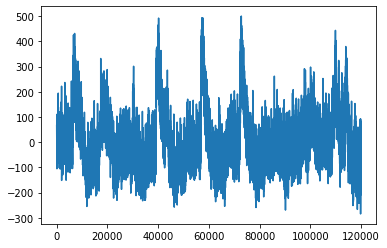

In [21]:
plt.plot(df["MEG0113"])